# Monte Carlo Simulations

This notebook explores the parameters space and looks for CH4 biosignature false positive scenarios from volcanism.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from joblib import Parallel, delayed
import multiprocessing
import time
from tqdm import tqdm
from scipy.interpolate import griddata
from scipy.stats import kde
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/')
from functions import *

In [2]:
# The total H and C mass fractions
mCO2tot=600e-6
mH2Otot=10000e-6

# set total pressure and temperature
T = 1473 # kelvin
P = 1 # bar
x = 0.01550152865954013
FMQ = -3.5

# set the Oxygen fugacity to FMQ
A = 25738
B = 9
C = 0.092
log_FMQ = (-A/T+B+C*(P-1)/T)
f_O2 = 10**(log_FMQ-3.5)
# set to FMQ

start = time.time()
P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(T,P,f_O2,mCO2tot,mH2Otot)
print(time.time()-start)
print('H2O mix rat =','%.2e'%(P_H2O/P))
print('H2 mix rat  =','%.2e'%(P_H2/P))
print('CO2 mix rat =','%.2e'%(P_CO2/P))
print('CO mix rat  =','%.2e'%(P_CO/P))
print('CH4 mix rat =','%.2e'%(P_CH4/P))

0.1495358943939209
H2O mix rat = 4.30e-01
H2 mix rat  = 5.45e-01
CO2 mix rat = 6.10e-03
CO mix rat  = 1.90e-02
CH4 mix rat = 4.57e-08


In [3]:
# make distributions
np.random.seed(0)
n = 10000

# Do SiO2 first
inputs = range(0,n)

# change these too
mCO2toto_r=[10e-6,1000e-6] # Approximate range in Earth MORB Wallace and Anderson 1999, Marty et al. 2012
mH2Ototo_r=[-5,-2] # Dissolved submarine range for Earth Wallace and Anderson 1999
                   # Figure 10
mCO2totc_r=[10e-6,1000e-6] # Approximate range in Earth MORB Wallance and Anderson 1999, Marty et al. 2012
mH2Ototc_r=[-3,-1] # Dissolved subaerial range for Earth Wallace and Anderson 1999
                   # Figure 11
mCO2toto = np.random.uniform(low=mCO2toto_r[0], high=mCO2toto_r[1], size=n)
mH2Ototo = 10**np.random.uniform(low=mH2Ototo_r[0], high=mH2Ototo_r[1], size=n)
mCO2totc = np.random.uniform(low=mCO2totc_r[0], high=mCO2totc_r[1], size=n)
mH2Ototc = 10**np.random.uniform(low=mH2Ototc_r[0], high=mH2Ototc_r[1], size=n)
#mCO2totc = mCO2toto
#mH2Ototc = 10**mH2Ototo

# Choose range of T and P and fO2
Tc_r = [873,1973] # coldest magmas to Komatiite magmas ( ,Huppert et al. 1984)
Pc_r = [1e-3,100] # Roughly subaerial degassing pressure range in the solar system
To_r = [873,1973] # coldest magmas to Komatiite magmas ( ,Huppert et al. 1984)
Po_r = [100,1000] # Magma solubility doesn't allow for siginifcant degassing at higher pressure
f_O2_r = [-4,5] # Range of O2 fugacities observed on Earth (Stamper et al. 2014)
                # White dwarfs pollution are evidence that similar O2 fuagacities on exoplanets (Doyle et al. 2019)
                # encompasses O2 fugacity of martian meteorites (Catling and Kasting 2017)
X_r = [0,1] # 0% to 100% subaerial volcanism

LG = 1
Delta_f_O2 = np.random.uniform(low=f_O2_r[0], high=f_O2_r[1], size=n)
Tc = np.random.uniform(low=Tc_r[0], high=Tc_r[1], size=n)
Pc = np.random.uniform(low=Pc_r[0], high=Pc_r[1], size=n)
To = np.random.uniform(low=To_r[0], high=To_r[1], size=n)
Po = np.random.uniform(low=Po_r[0], high=Po_r[1], size=n)
X = np.random.uniform(low=X_r[0], high=X_r[1], size=n)
if LG==1:
    # log stuff
    Pc_r = [np.log10(Pc_r[0]),np.log10(Pc_r[1])]
    Pc = 10**np.random.uniform(low=Pc_r[0], high=Pc_r[1], size=n)


# little bit more to get f_O2
A = 25738
B = 9
C = 0.092
log_fO2_c = (-A/Tc+B+C*(Pc-1)/Tc)+Delta_f_O2
f_O2_c = 10**(log_fO2_c)

log_fO2_o = (-A/To+B+C*(Po-1)/To)+Delta_f_O2
f_O2_o = 10**(log_fO2_o)

In [4]:
# ocean world or just continental world
def flux_ratios_iter(T,P,f_O2,mCO2tot,mH2Otot):
    P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(T,P,f_O2,mCO2tot,mH2Otot)
    #CO_CO2 = P_CO/P_CO2
    CO_CO2 = P_CO2/P_CO
    CO_CH4 = P_CH4/P_CO
    

    return (CO_CO2,CO_CH4,1000*alphaG*x*(1/(1-alphaG))*P_CO/P,1000*alphaG*x*(1/(1-alphaG))*P_CH4/P)

num_cores = multiprocessing.cpu_count()
start = time.time()
resultso = Parallel(n_jobs=num_cores)(delayed(flux_ratios_iter)\
            (To[i],Po[i],f_O2_o[i],mCO2toto[i],mH2Ototo[i]) for i in tqdm(inputs))
end = time.time()
print(end-start)

resultso = np.array(resultso)

100%|██████████| 10000/10000 [00:25<00:00, 393.33it/s]


25.933892965316772


In [5]:
# ocean world or just continental world
def flux_ratios_iter(T,P,f_O2,mCO2tot,mH2Otot):
    P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(T,P,f_O2,mCO2tot,mH2Otot)
    #CO_CO2 = P_CO/P_CO2
    CO_CO2 = P_CO2/P_CO
    CO_CH4 = P_CH4/P_CO
    

    return (CO_CO2,CO_CH4,1000*alphaG*x*(1/(1-alphaG))*P_CO2/P,1000*alphaG*x*(1/(1-alphaG))*P_CH4/P)

num_cores = multiprocessing.cpu_count()
start = time.time()
resultsc = Parallel(n_jobs=num_cores)(delayed(flux_ratios_iter)\
            (Tc[i],Pc[i],f_O2_c[i],mCO2totc[i],mH2Ototc[i]) for i in tqdm(inputs))
end = time.time()
print(end-start)

resultsc = np.array(resultsc)

100%|██████████| 10000/10000 [00:34<00:00, 289.96it/s]


34.82929491996765


In [6]:
# mix land-ocean world
def flux_ratios_iter(To,Tc,Po,Pc,f_O2_o,f_O2_c,mCO2toto,mH2Ototo,mCO2totc,mH2Ototc,X):
    P_H2O_o,P_H2_o,P_CO2_o,P_CO_o,P_CH4_o,alphaG_o,x_CO2_o,x_H2O_o = solve_gases(To,Po,f_O2_o,mCO2toto,mH2Ototo)    
    P_H2O_c,P_H2_c,P_CO2_c,P_CO_c,P_CH4_c,alphaG_c,x_CO2_c,x_H2O_c = solve_gases(Tc,Pc,f_O2_c,mCO2totc,mH2Ototc)
    
    P_CO2_b = X*(P_CO2_c/Pc)+(1-X)*(P_CO2_o/Po)
    P_CO_b = X*(P_CO_c/Pc)+(1-X)*(P_CO_o/Po)
    P_CH4_b = X*(P_CH4_c/Pc)+(1-X)*(P_CH4_o/Po)
    
    CO_CO2 = P_CO2_b/P_CO_b
    CO_CH4 = P_CH4_b/P_CO_b
    
    #CO_CO2 = X*(P_CO_c/P_CO2_c)+(1-X)*(P_CO_o/P_CO2_o)
    #CO_CH4 = X*(P_CO_c/P_CH4_c)+(1-X)*(P_CO_o/P_CH4_o)

    return (CO_CO2,CO_CH4,P_CO2_b,P_CH4_b)

num_cores = multiprocessing.cpu_count()
start = time.time()
resultsb = Parallel(n_jobs=num_cores)(delayed(flux_ratios_iter)\
            (To[i],Tc[i],Po[i],Pc[i],f_O2_o[i],f_O2_c[i],mCO2toto[i],mH2Ototo[i],mCO2totc[i],mH2Ototc[i],X[i]) for i in tqdm(inputs))
end = time.time()
print(end-start)

resultsb = np.array(resultsb)

100%|██████████| 10000/10000 [01:12<00:00, 137.47it/s]


73.41304612159729


In [225]:
#np.savetxt('ocean_world.txt',resultso)
#resultso = np.loadtxt('ocean_world.txt')

#np.savetxt('ocean_continent_combo.txt',resultsb)
#resultsb = np.loadtxt('ocean_continent_combo.txt')

## A few plots

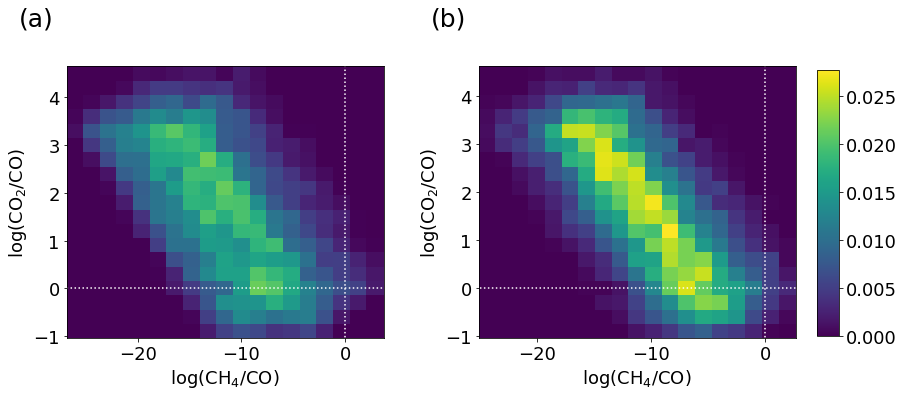

In [11]:
plt.rcParams.update({'font.size': 18})

fig,[ax,ax1] = plt.subplots(1,2,figsize=[15,5])
results = resultsb
xbins = np.linspace(np.log10(min(results[:,1])), np.log10(max(results[:,1])), 20)
ybins = np.linspace(np.log10(min(results[:,0])), np.log10(max(results[:,0])), 20)
counts1, _, _ = np.histogram2d(np.log10(results[:,1]), np.log10(results[:,0]), bins=(xbins, ybins),normed=True)
cs1 = ax1.pcolormesh(xbins, ybins, counts1.T,vmin=0, vmax=np.max(counts1))
#ax1.set_ylabel(r"$\log(\mathrm{CO}/\mathrm{CO_2})$")
#ax1.set_xlabel(r"$\log(\mathrm{CO}/\mathrm{CH_4})$")
ax1.set_ylabel(r"$\log(\mathrm{CO_2}/\mathrm{CO})$")
ax1.set_xlabel(r"$\log(\mathrm{CH_4}/\mathrm{CO})$")
#ax1.set_xticks(np.arange(0,22,5))
#cbar1 = plt.colorbar(cs1,ax=ax1)
#cbar1.set_label("Probability density")


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.13, 0.02, 0.74])
fig.colorbar(cs1, cax=cbar_ax)

results = resultso
xbins = np.linspace(np.log10(min(results[:,1])), np.log10(max(results[:,1])), 20)
ybins = np.linspace(np.log10(min(results[:,0])), np.log10(max(results[:,0])), 20)
#counts, _, _ = np.histogram2d(np.log10(results[:,1]), np.log10(results[:,0]), bins=(xbins, ybins),normed=True)
#cs = ax.pcolormesh(xbins, ybins, counts.T,vmin=0, vmax=np.max(counts1))
ax.hist2d(np.log10(results[:,1]), np.log10(results[:,0]),bins=(xbins, ybins),normed=True,vmax=np.max(counts1))
#ax.set_ylabel(r"$\log(\mathrm{CO}/\mathrm{CO_2})$")
#ax.set_xlabel(r"$\log(\mathrm{CO}/\mathrm{CH_4})$")
ax.set_ylabel(r"$\log(\mathrm{CO_2}/\mathrm{CO})$")
ax.set_xlabel(r"$\log(\mathrm{CH_4}/\mathrm{CO})$")
#cbar = plt.colorbar(cs,ax=ax)
#cbar.set_label("Probability density")
#ax.set_xticks(np.arange(0,22,5))
plt.subplots_adjust(wspace=.3)

ax.text(-0.15, 1.15, '(a)', transform=ax.transAxes,size=25)
ax1.text(-0.15, 1.15, '(b)', transform=ax1.transAxes,size=25)


ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])
ax1.set_ylim(ax1.get_ylim()[0],ax1.get_ylim()[1])
ax1.set_xlim(ax1.get_xlim()[0],ax1.get_xlim()[1])
xxx = np.linspace(-40,10)
ax.plot(xxx,xxx*0,'w:')
ax.plot(xxx*0,xxx,'w:')

ax1.plot(xxx,xxx*0,'w:')
ax1.plot(xxx*0,xxx,'w:')

#plt.savefig("both.pdf",bbox_inches='tight')

plt.show()

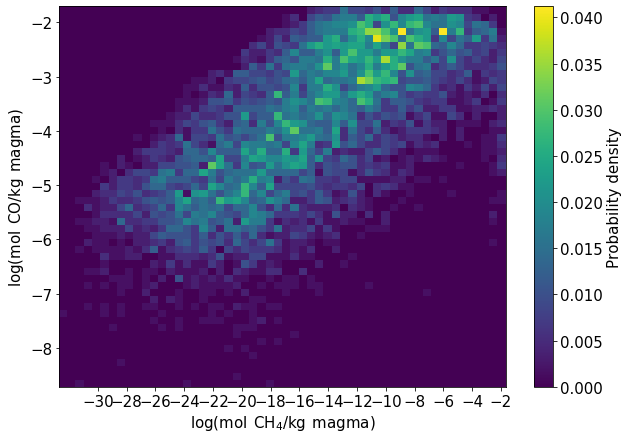

In [31]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[10,7])
results = resultso

xx = np.log10(results[~np.isnan(results[:,3]),3])
yy = np.log10(results[~np.isnan(results[:,2]),2])

xbins = np.linspace(np.min(xx), np.max(xx), 55)
                    
                    
ybins = np.linspace(np.min(yy), np.max(yy), 55)
                    
                    
counts, _, _ = np.histogram2d(xx, yy, bins=(xbins, ybins),normed=True)
cs = ax.pcolormesh(xbins, ybins, counts.T)#,vmin=0, vmax=.025)
#ax.set_ylabel(r"$\log(\mathrm{CO}/\mathrm{CO_2})$")
#ax.set_xlabel(r"$\log(\mathrm{CO}/\mathrm{CH_4})$")
#ax.set_xlim(-10,0)
ax.set_xticks(np.arange(-30,np.max(xx),2))
ax.set_ylabel(r"$\log(\mathrm{mol\:\:CO}/\mathrm{kg\:\: magma})$")
ax.set_xlabel(r"$\log(\mathrm{mol\:\:CH_4}/\mathrm{kg\:\: magma})$")
cbar = plt.colorbar(cs,ax=ax)
cbar.set_label("Probability density")

#plt.savefig("test.jpg",bbox_inches='tight')

plt.show()

# Check where CO/CH4 <1

In [35]:
results = resultso
ind = []
j = 0
for i in range(0,len(results[:,1])):
    if results[i,3]>1e-2 and results[i,2]<1e-4:
        j+=1


        ind.append(i)
    if j>3:
        break
        

        
print('Oxgen Fugacity (FMQ) =',Delta_f_O2[ind])
print('T_ocean (K) =         ',To[ind])
print('P_ocean (bar) =       ',Po[ind])
print('T_cont (K) =          ',Tc[ind])
print('P_cont (bar) =        ',Pc[ind])
print('ocean CO2 (ppm wt) =  ',[round(1e6*a) for a in mCO2toto[ind]])
print('ocean H2O (ppm wt) =   ',[round(1e6*a) for a in mH2Ototo[ind]])
print('cont CO2 (ppm wt) =  ',[round(1e6*a) for a in mCO2totc[ind]])
print('cont H2O (ppm wt) =   ',[round(1e6*a) for a in mH2Ototc[ind]])
print('X                  =  ',X[ind])
print()

k = 0
P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(To[ind[k]],1,f_O2_o[ind[k]],mCO2toto[ind[k]],mH2Ototo[ind[k]])
print('Ocean properties')
print('H2O mix rat =','%.2e'%(P_H2O/Po[ind[k]]))
print('H2 mix rat  =','%.2e'%(P_H2/Po[ind[k]]))
print('CO2 mix rat =','%.2e'%(P_CO2/Po[ind[k]]))
print('CO mix rat  =','%.2e'%(P_CO/Po[ind[k]]))
print('CH4 mix rat =','%.2e'%(P_CH4/Po[ind[k]]))

P_H2Oc,P_H2c,P_CO2c,P_COc,P_CH4c,alphaG,x_CO2,x_H2O = solve_gases(Tc[ind[k]],Pc[ind[k]],f_O2_c[ind[k]],mCO2totc[ind[k]],mH2Ototc[ind[k]])
print()
print('Cont properties')
print('H2O mix rat =','%.2e'%(P_H2Oc/Pc[ind[k]]))
print('H2 mix rat  =','%.2e'%(P_H2c/Pc[ind[k]]))
print('CO2 mix rat =','%.2e'%(P_CO2c/Pc[ind[k]]))
print('CO mix rat  =','%.2e'%(P_COc/Pc[ind[k]]))
print('CH4 mix rat =','%.2e'%(P_CH4c/Pc[ind[k]]))


print()
print('both combined')
print('H2O mix rat =','%.2e'%(X[ind[k]]*(P_H2Oc/Pc[ind[k]])+(1-X[ind[k]])*(P_H2O/Po[ind[k]])))
print('H2 mix rat =','%.2e'%(X[ind[k]]*(P_H2c/Pc[ind[k]])+(1-X[ind[k]])*(P_H2/Po[ind[k]])))
print('CO2 mix rat =','%.2e'%(X[ind[k]]*(P_CO2c/Pc[ind[k]])+(1-X[ind[k]])*(P_CO2/Po[ind[k]])))
print('CO mix rat =','%.2e'%(X[ind[k]]*(P_COc/Pc[ind[k]])+(1-X[ind[k]])*(P_CO/Po[ind[k]])))
print('CH4 mix rat =','%.2e'%(X[ind[k]]*(P_CH4c/Pc[ind[k]])+(1-X[ind[k]])*(P_CH4/Po[ind[k]])))

print((X[ind[k]]*(P_H2Oc/Pc[ind[k]])+(1-X[ind[k]])*(P_H2O/Po[ind[k]]))+\
     (X[ind[k]]*(P_H2c/Pc[ind[k]])+(1-X[ind[k]])*(P_H2/Po[ind[k]]))+\
     (X[ind[k]]*(P_CO2c/Pc[ind[k]])+(1-X[ind[k]])*(P_CO2/Po[ind[k]]))+\
     (X[ind[k]]*(P_COc/Pc[ind[k]])+(1-X[ind[k]])*(P_CO/Po[ind[k]]))+\
     (X[ind[k]]*(P_CH4c/Pc[ind[k]])+(1-X[ind[k]])*(P_CH4/Po[ind[k]])))

Oxgen Fugacity (FMQ) = [-3.56518755 -3.92932352 -3.87852361 -3.57512609]
T_ocean (K) =          [937.34423924 906.40646772 976.67666402 962.39068997]
P_ocean (bar) =        [779.81710297 751.9340587  566.56588762 575.28361363]
T_cont (K) =           [ 968.64332885 1245.24307439 1100.30562085 1750.72601278]
P_cont (bar) =         [1.00239951e-01 3.38543454e-03 4.80050200e+00 7.11164489e-03]
ocean CO2 (ppm wt) =   [985.0, 481.0, 987.0, 832.0]
ocean H2O (ppm wt) =    [7154.0, 3306.0, 7005.0, 7065.0]
cont CO2 (ppm wt) =   [525.0, 287.0, 739.0, 774.0]
cont H2O (ppm wt) =    [11441.0, 5027.0, 16522.0, 1107.0]
X                  =   [0.34139476 0.93873536 0.74773939 0.61894951]

Ocean properties
H2O mix rat = 5.52e-04
H2 mix rat  = 6.58e-04
CO2 mix rat = 4.55e-05
CO mix rat  = 2.59e-05
CH4 mix rat = 1.70e-06

Cont properties
H2O mix rat = 4.25e-01
H2 mix rat  = 5.56e-01
CO2 mix rat = 1.08e-02
CO mix rat  = 7.82e-03
CH4 mix rat = 2.65e-06

both combined
H2O mix rat = 1.46e-01
H2 mix rat = 1.90

# Bunch of plots

Everything below here is just a bunch of random plots to help me understand what the model is doing.

In [13]:
mCO2tot=500e-6
mH2Otot=10000e-6

# set total pressure and temperature
n = 15
m = 15
T = np.linspace(1000,2000,n) # kelvin
P = 1000 # bar
FMQ = np.linspace(-5,2,m)
CO_CH4 = np.zeros([n,m])

for i in range(0,len(T)):
    for j in range(0,len(FMQ)):
        # set the Oxygen fugacity to FMQ
        A = 25738
        B = 9
        C = 0.092
        log_FMQ = (-A/T[i]+B+C*(P-1)/T[i])
        f_O2 = 10**(log_FMQ+FMQ[j])
        # set to FMQ


        P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(T[i],P,f_O2,mCO2tot,mH2Otot)
        CO_CH4[i,j] = P_CO/P_CH4

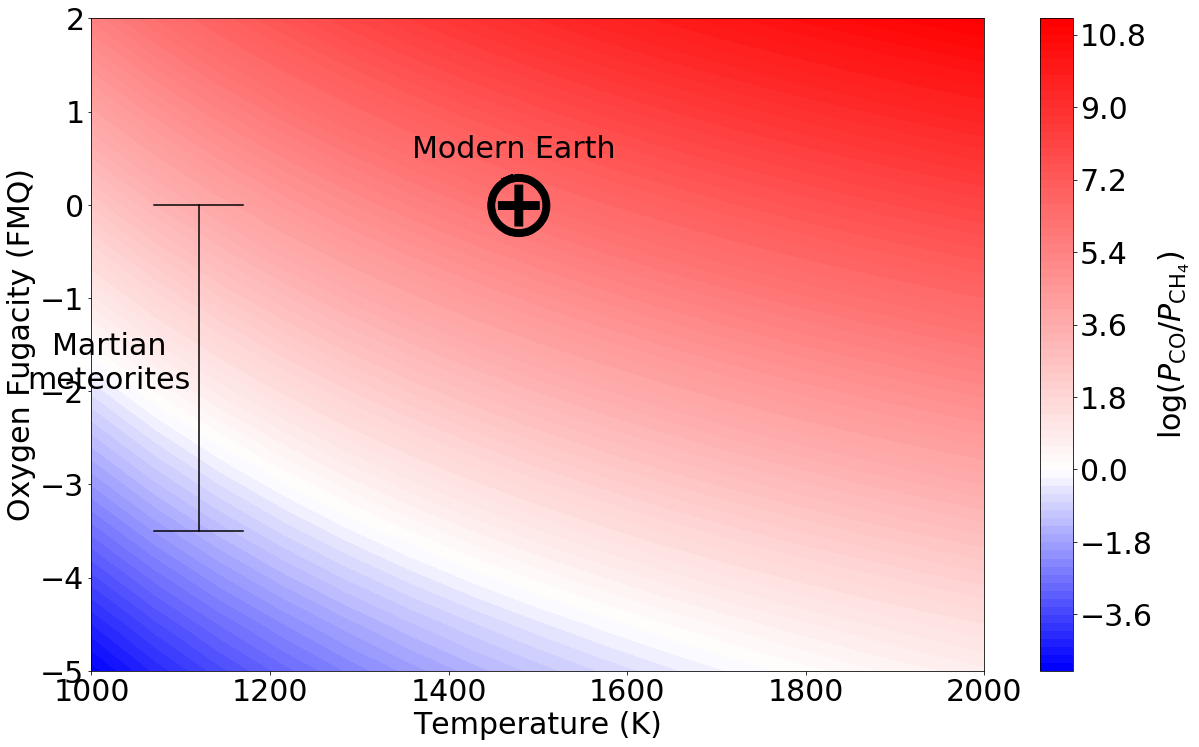

In [14]:
# plot
plt.rcParams.update({'font.size': 30})
divnorm = colors.DivergingNorm(vmin=np.min(np.log10(CO_CH4.T)), vcenter=0., vmax=np.max(np.log10(CO_CH4.T)))

fig,ax = plt.subplots(1,1,figsize = [20,12])
cs = ax.contourf(T,FMQ, np.log10(CO_CH4.T), 100,cmap ='bwr',norm=divnorm)
cbar = plt.colorbar(cs,ax=ax)  # draw colorbar
cbar.set_label(r"$\log(P_{\mathrm{CO}}/P_{\mathrm{CH_4}})$")

ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Oxygen Fugacity (FMQ)')

shft = 520
ax.plot([600+shft,600+shft],[-3.5,0],clip_on=False,color='k')
ax.plot([550+shft,650+shft],[-3.5,-3.5],clip_on=False,color='k')
ax.plot([550+shft,650+shft],[0,0],clip_on=False,color='k')
ax.text(850+shft-350,-1.7,"Martian\nmeteorites",verticalalignment='center',horizontalalignment='center',color='k')

#ax.arrow(750+shft,0,-200,0,head_width=.2,head_length=40,fc='k',color='k')
#ax.text(1100+10+shft,0,"Modern Earth upper\nmantle average",verticalalignment='center',horizontalalignment='center',color='k')
ax.scatter(1473,0,marker=r'$\oplus$',s=5000, c='k',zorder=10)
ax.text(1473,0+.5,"Modern Earth",horizontalalignment='center',color='k')

#plt.savefig("test1.pdf",bbox_inches='tight')

plt.show()

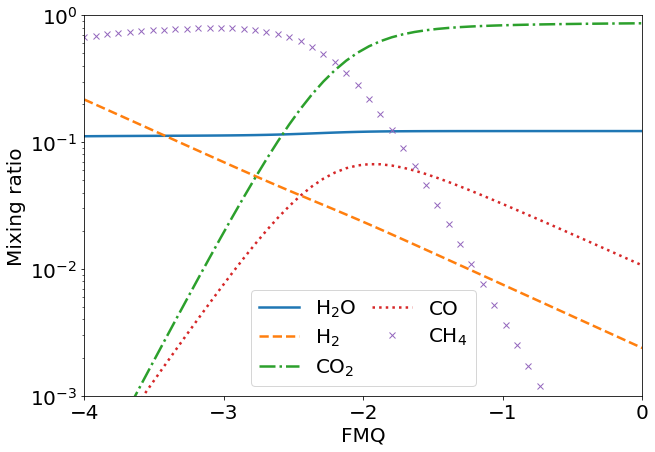

In [12]:
mCO2tot=500e-6
mH2Otot=10000e-6

# set total pressure and temperature
n = 50
T = 1000 # kelvin
P = 1000 # bar
FMQ = np.linspace(-4,0,n)

H2O = []
H2 = []
CO2 = []
CO = []
CH4 = []
ff_O2 = []
for i in range(0,n):
    TT = T
    # set the Oxygen fugacity to FMQ
    A = 25738
    B = 9
    C = 0.092
    log_FMQ = (-A/TT+B+C*(P-1)/TT)
    f_O2 = 10**(log_FMQ+FMQ[i])
    # set to FMQ
    
    ff_O2.append(f_O2)


    P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(TT,P,f_O2,mCO2tot,mH2Otot)
    H2O.append(P_H2O/P)
    H2.append(P_H2/P)
    CO2.append(P_CO2/P)
    CO.append(P_CO/P)
    CH4.append(P_CH4/P)
    
    
plt.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(1,1,figsize = [10,7])

ax.plot(FMQ,H2O,'-',label='$\mathrm{H_2O}$',linewidth=2.5)
ax.plot(FMQ,H2,'--',label='$\mathrm{H_2}$',linewidth=2.5)
ax.plot(FMQ,CO2,'-.',label='$\mathrm{CO_2}$',linewidth=2.5)
ax.plot(FMQ,CO,':',label='$\mathrm{CO}$',linewidth=2.5)
ax.plot(FMQ,CH4,'x',label='$\mathrm{CH_4}$',linewidth=2.5)

ax.set_yscale('log')

ax.set_xlim(min(FMQ),max(FMQ))
ax.set_ylim(1e-3,1)
#ax.set_yticks(np.arange(-3,1,1))
ax.set_xticks(np.arange(-4,1,1))

ax.set_xlabel('FMQ')
ax.set_ylabel('Mixing ratio')

plt.legend(ncol=2,columnspacing=.8,labelspacing=.4)

#plt.savefig("worst_case1.pdf",bbox_inches='tight')

plt.show()

In [33]:
10**-19.6

2.5118864315095717e-20

In [27]:
# inputs
mCO2tot=1000e-6
mH2Otot=1000e-6
T = 1000 # kelvin
P = 400 # bar
FMQ = -2.2

M_H2O = 18.01528
M_CO2 = 44.01
x = 0.01550152865954013
xCO2tot=(mCO2tot/M_CO2)/x
xH2Otot=(mH2Otot/M_H2O)/x

# set the Oxygen fugacity
A = 25738
B = 9
C = 0.092
log_FMQ = (-A/T+B+C*(P-1)/T)
f_O2 = 10**(log_FMQ+FMQ)
# set to FMQ

P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(T,P,f_O2,mCO2tot,mH2Otot)

m_CO2 = M_CO2*x*x_CO2
m_H2O = M_H2O*x*x_H2O

print('H2O mix rat =','%.2e'%(P_H2O/P))
print('H2 mix rat  =','%.2e'%(P_H2/P))
print('CO2 mix rat =','%.2e'%(P_CO2/P))
print('CO mix rat  =','%.2e'%(P_CO/P))
print('CH4 mix rat =','%.2e'%(P_CH4/P))
print()

print('alphaG =',alphaG)
print('Percent CO2 in basalt =',100*x_CO2/xCO2tot)
print('Percent H2O in basalt =',100*x_H2O/xH2Otot)
print('PPM by wt CO2 in basalt =',m_CO2*1e6)
print('PPM by wt H2O in basalt =',m_H2O*1e6)

print()

print('mol H2O/kg magma =','%.2e'%(1000*alphaG*x*(1/(1-alphaG))*P_H2O/P))
print('mol H2/kg magma =','%.2e'%(1000*alphaG*x*(1/(1-alphaG))*P_H2/P))
print('mol CO2/kg magma =','%.2e'%(1000*alphaG*x*(1/(1-alphaG))*P_CO2/P))
print('mol CO/kg magma =','%.2e'%(1000*alphaG*x*(1/(1-alphaG))*P_CO/P))
print('mol CH4/kg magma =','%.2e'%(1000*alphaG*x*(1/(1-alphaG))*P_CH4/P))
print()
print('mol H2 tot/kg magma =','%.2e'%((1000*alphaG*x*(1/(1-alphaG))*P_H2O/P)+(1000*alphaG*x*(1/(1-alphaG))*P_H2/P)+2*(1000*alphaG*x*(1/(1-alphaG))*P_CH4/P)))
print('mol C tot/kg magma =','%.2e'%((1000*alphaG*x*(1/(1-alphaG))*P_CO2/P)+(1000*alphaG*x*(1/(1-alphaG))*P_CO/P)+(1000*alphaG*x*(1/(1-alphaG))*P_CH4/P)))
print()
# fluxes
Pcrust = 6e13 #earth value
print('CH4 flux (Tmol/yr) =','%.2e'%((1e-12*1000*alphaG*x*(1/(1-alphaG))*P_CH4/P)*Pcrust))
print('CO flux (Tmol/yr) =','%.2e'%((1e-12*1000*alphaG*x*(1/(1-alphaG))*P_CO/P)*Pcrust))
print('CO2 flux (Tmol/yr) =','%.2e'%((1e-12*1000*alphaG*x*(1/(1-alphaG))*P_CO2/P)*Pcrust))




H2O mix rat = 1.11e-01
H2 mix rat  = 2.72e-02
CO2 mix rat = 4.02e-01
CO mix rat  = 6.25e-02
CH4 mix rat = 3.97e-01

alphaG = 0.0012305112865992926
Percent CO2 in basalt = 24.089130899004353
Percent H2O in basalt = 93.31843505117916
PPM by wt CO2 in basalt = 240.89130899004357
PPM by wt H2O in basalt = 9331.843505117913

mol H2O/kg magma = 2.12e-03
mol H2/kg magma = 5.20e-04
mol CO2/kg magma = 7.69e-03
mol CO/kg magma = 1.19e-03
mol CH4/kg magma = 7.58e-03

mol H2 tot/kg magma = 1.78e-02
mol C tot/kg magma = 1.65e-02

CH4 flux (Tmol/yr) = 4.55e-01
CO flux (Tmol/yr) = 7.16e-02
CO2 flux (Tmol/yr) = 4.61e-01


In [64]:
mCO2tot=500e-6
mH2Otot=10000e-6

# set total pressure and temperature
n = 15
m = 15
T = np.linspace(1000,2000,n) # kelvin
P = 1000 # bar
FMQ = np.linspace(-5,2,m)
CH4 = np.zeros([n,m])
CO = np.zeros([n,m])
CO2 = np.zeros([n,m])
H2O = np.zeros([n,m])

tot_H2 = np.zeros([n,m])
tot_C = np.zeros([n,m])

for i in range(0,len(T)):
    for j in range(0,len(FMQ)):
        # set the Oxygen fugacity to FMQ
        A = 25738
        B = 9
        C = 0.092
        log_FMQ = (-A/T[i]+B+C*(P-1)/T[i])
        f_O2 = 10**(log_FMQ+FMQ[j])
        # set to FMQ


        P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(T[i],P,f_O2,mCO2tot,mH2Otot)
        CH4[i,j] = 1000*alphaG*x*(1/(1-alphaG))*P_CH4/P
        CO[i,j] = 1000*alphaG*x*(1/(1-alphaG))*P_CO/P
        CO2[i,j] = 1000*alphaG*x*(1/(1-alphaG))*P_CO2/P
        H2O[i,j] = 1000*alphaG*x*(1/(1-alphaG))*P_H2O/P
        
        tot_H2[i,j] = ((1000*alphaG*x*(1/(1-alphaG))*P_H2O/P)+(1000*alphaG*x*(1/(1-alphaG))*P_H2/P)+2*(1000*alphaG*x*(1/(1-alphaG))*P_CH4/P))

        

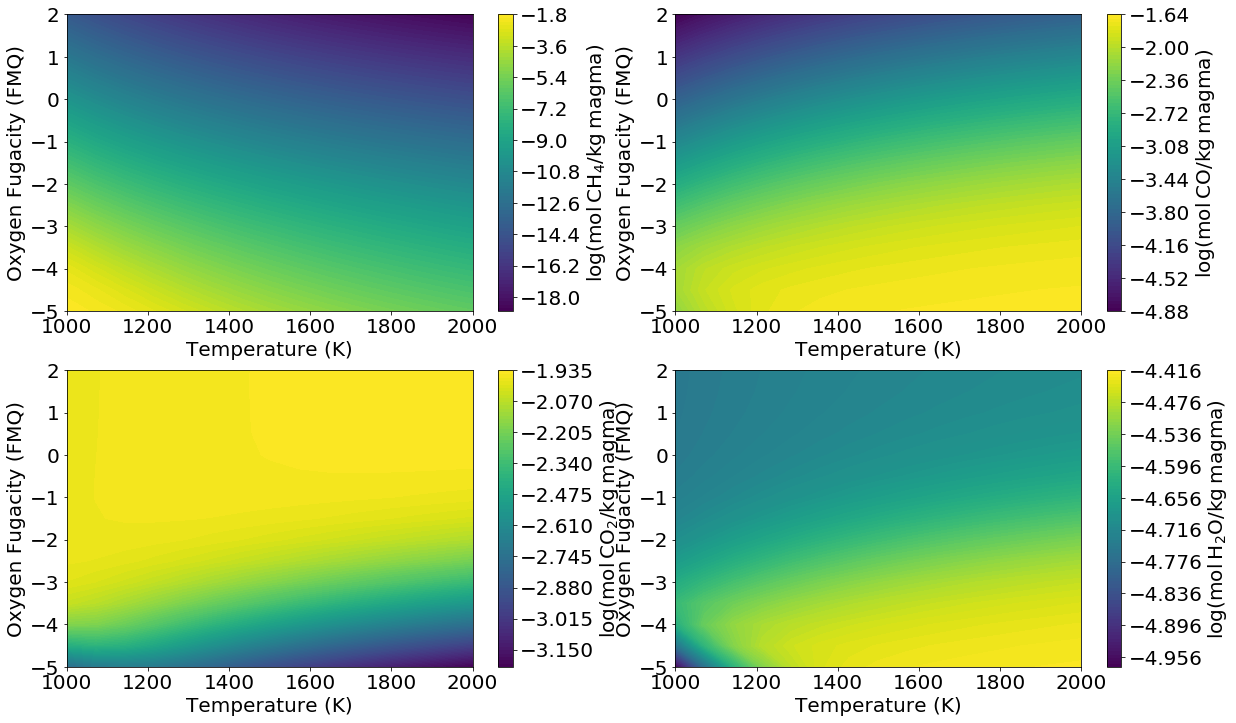

In [66]:
# plot
plt.rcParams.update({'font.size': 20})
#divnorm = colors.DivergingNorm(vmin=np.min(np.log10(CH4.T)), vcenter=0., vmax[0,0]=np.max[0,0](np.log10(CH4.T)))

fig,ax = plt.subplots(2,2,figsize = [20,12])

cs = ax[0,0].contourf(T,FMQ, np.log10(CH4.T), 100)
cbar = plt.colorbar(cs,ax=ax[0,0])  # draw colorbar
cbar.set_label(r"$\mathrm{\log(mol\:CH_4/kg\:magma)}$")
ax[0,0].set_ylim(ax[0,0].get_ylim()[0],ax[0,0].get_ylim()[1])
ax[0,0].set_xlim(ax[0,0].get_xlim()[0],ax[0,0].get_xlim()[1])
ax[0,0].set_xlabel('Temperature (K)')
ax[0,0].set_ylabel('Oxygen Fugacity (FMQ)')


cs = ax[0,1].contourf(T,FMQ, np.log10(CO.T), 100)
cbar = plt.colorbar(cs,ax=ax[0,1])  # draw colorbar
cbar.set_label(r"$\mathrm{\log(mol\:CO/kg\:magma)}$")
ax[0,1].set_ylim(ax[0,1].get_ylim()[0],ax[0,1].get_ylim()[1])
ax[0,1].set_xlim(ax[0,1].get_xlim()[0],ax[0,1].get_xlim()[1])
ax[0,1].set_xlabel('Temperature (K)')
ax[0,1].set_ylabel('Oxygen Fugacity (FMQ)')


cs = ax[1,0].contourf(T,FMQ, np.log10(CO2.T), 100)
cbar = plt.colorbar(cs,ax=ax[1,0])  # draw colorbar
cbar.set_label(r"$\mathrm{\log(mol\:CO_2/kg\:magma)}$")
ax[1,0].set_ylim(ax[1,0].get_ylim()[0],ax[1,0].get_ylim()[1])
ax[1,0].set_xlim(ax[1,0].get_xlim()[0],ax[1,0].get_xlim()[1])
ax[1,0].set_xlabel('Temperature (K)')
ax[1,0].set_ylabel('Oxygen Fugacity (FMQ)')


cs = ax[1,1].contourf(T,FMQ, np.log10(H2O.T), 100)
cbar = plt.colorbar(cs,ax=ax[1,1])  # draw colorbar
cbar.set_label(r"$\mathrm{\log(mol\:H_2O/kg\:magma)}$")
ax[1,1].set_ylim(ax[1,1].get_ylim()[0],ax[1,1].get_ylim()[1])
ax[1,1].set_xlim(ax[1,1].get_xlim()[0],ax[1,1].get_xlim()[1])
ax[1,1].set_xlabel('Temperature (K)')
ax[1,1].set_ylabel('Oxygen Fugacity (FMQ)')

#shft = 520
#ax[0,0].plot([600+shft,600+shft],[-3.5,0],clip_on=False,color='k')
#ax[0,0].plot([550+shft,650+shft],[-3.5,-3.5],clip_on=False,color='k')
#ax[0,0].plot([550+shft,650+shft],[0,0],clip_on=False,color='k')
#ax[0,0].text(850+shft-350,-1.7,"Martian\nmeteorites",verticalalignment='center',horizontalalignment='center',color='k')

#ax[0,0].arrow(750+shft,0,-200,0,head_width=.2,head_length=40,fc='k',color='k')
#ax[0,0].text(1100+10+shft,0,"Modern Earth upper\nmantle average",verticalalignment='center',horizontalalignment='center',color='k')
#ax[0,0].scatter(1473,0,marker=r'$\oplus$',s=5000, c='k',zorder=10)
#ax[0,0].text(1473,0+.5,"Modern Earth",horizontalalignment='center',color='k')

#plt.savefig("test1.pdf",bbox_inches='tight')

plt.show()

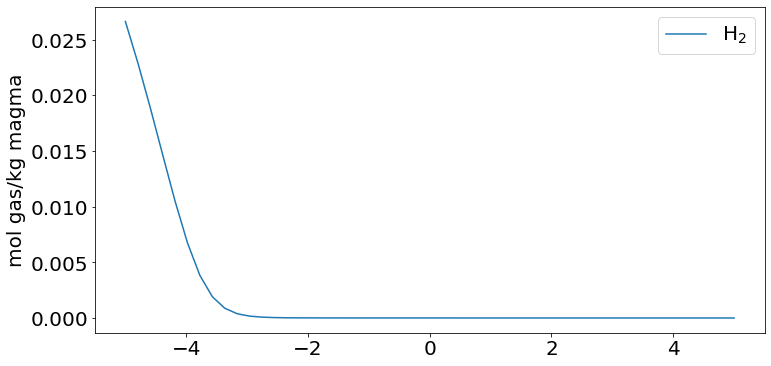

In [25]:
mCO2tot=1000e-6
mH2Otot=1000e-6

# set total pressure and temperature
n = 50
T = 1000 # kelvin
PP = np.logspace(0,3) # bar
PP = 1000
FMQ = np.linspace(-5,5,n)

tot_H2 = []
tot_C = []

H2O = []

for i in range(0,n):
    P = PP
    TT = T
    # set the Oxygen fugacity to FMQ
    A = 25738
    B = 9
    C = 0.092
    log_FMQ = (-A/TT+B+C*(P-1)/TT)
    f_O2 = 10**(log_FMQ+FMQ[i])
    # set to FMQ
    


    P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(TT,P,f_O2,mCO2tot,mH2Otot)
    tot_H2.append(((1000*alphaG*x*(1/(1-alphaG))*P_H2O/P)+(1000*alphaG*x*(1/(1-alphaG))*P_H2/P)+2*(1000*alphaG*x*(1/(1-alphaG))*P_CH4/P)))
    tot_C.append(((1000*alphaG*x*(1/(1-alphaG))*P_CO2/P)+(1000*alphaG*x*(1/(1-alphaG))*P_CO/P)+(1000*alphaG*x*(1/(1-alphaG))*P_CH4/P)))
    H2O.append((1000*alphaG*x*(1/(1-alphaG))*P_H2O/P))
    
    
plt.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(1,1,figsize = [12,6])

ax.plot(FMQ,tot_H2,label='$\mathrm{H_2}$')
#ax.plot(FMQ,tot_C,label='$\mathrm{C}$')


#ax.set_xlabel('Pressure (bar)')
ax.set_ylabel('mol gas/kg magma')

plt.legend()

plt.show()